In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Create data
1. Create $k$ random points in $[0,1]^2$
2. Choose a pair of points and add 1-3 points random convex combinations.
3. Repeat 2 $m$ times

6 3
8 0
8 2
3 5
2 6
6 9
1 6
4 9
8 0
7 5


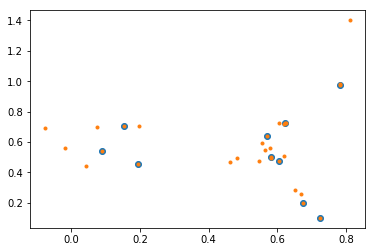

In [195]:
k=10
D=random.rand(2,k)
plot(D[0,:],D[1,:],'o');

l=10
for i in range(l):
    i1,i2=random.choice(k,2,replace=False)
    print(i1,i2)
    P1=D[:,i1:i1+1]; P2=D[:,i2:i2+1]
    for j in range(2):
        alpha=random.rand()*2.-1. # choose a random number between 0 an 1
        new=(P1+P2)/2.+alpha*(P1-P2)
        D=append(D,new,axis=1)
plot(D[0,:],D[1,:],'.');

### We compute the line parameters for each pair of points.
Suppose the points are $(x_1,y_1)$ and $(x_2,y_2)$.

* If $x_1=x_2$ this is a vertical line which we represent by $(x_1,nan)$
* If $x_1 \neq x_2$ then we use $(a,b)$ such that $ax_1+b=y_1$ and $a x_2 +b=y_2$. The solution to which is is $a=\frac{y_1-y_2}{x_1-x_2}$, $b=y_1-a x_1$

In [196]:
#find colinearity
def tag(D1,D2):
    accuracy=100000.
    def R(x):
        return int(x*accuracy)/accuracy

    if D1[0]==D2[0]:  # vertical pair
        return (R(D1[0]),np.nan)
    else:
        a=(D1[1]-D2[1])/(D1[0]-D2[0])
        b=D1[1]-a*D1[0]
        return (R(a),R(b))

Pairs=[]
n=D.shape[1]
for i in range(n):
    for j in range(i+1,n):
        Pairs.append(((i,j),tag(D[:,i],D[:,j])))
#Pairs


In [197]:
sorted(Pairs,key=lambda x:x[1])

[((10, 14), (-1705.51093, 1056.22134)),
 ((15, 23), (-17.35451, 11.57448)),
 ((8, 23), (-16.07805, 10.74386)),
 ((10, 26), (-14.69885, 9.60732)),
 ((14, 23), (-13.64618, 9.16137)),
 ((2, 6), (-12.99162, 8.05396)),
 ((2, 18), (-12.99162, 8.05396)),
 ((2, 19), (-12.99162, 8.05396)),
 ((6, 18), (-12.99162, 8.05396)),
 ((6, 19), (-12.99162, 8.05396)),
 ((18, 19), (-12.99162, 8.05396)),
 ((7, 12), (-11.65103, 1.58385)),
 ((15, 21), (-10.87364, 7.52325)),
 ((1, 15), (-10.40529, 7.23048)),
 ((8, 21), (-10.35959, 7.17978)),
 ((1, 8), (-9.97957, 6.94293)),
 ((23, 26), (-9.53088, 6.48343)),
 ((14, 21), (-9.29603, 6.46915)),
 ((1, 14), (-9.08237, 6.33692)),
 ((1, 21), (-7.63661, 5.3604)),
 ((1, 26), (-7.32664, 5.15103)),
 ((21, 26), (-7.29119, 5.1296)),
 ((10, 23), (-7.16431, 4.94344)),
 ((9, 15), (-6.34582, 4.69288)),
 ((8, 9), (-6.19923, 4.5868)),
 ((0, 3), (-5.97902, 1.62265)),
 ((9, 14), (-5.8727, 4.35052)),
 ((1, 10), (-5.42893, 3.86923)),
 ((9, 26), (-5.21492, 3.87456)),
 ((10, 21), (-5.101

In [1]:
#start the SparkContext
import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext(master="local[4]")

In [199]:
D_list = [(i,D[:,i]) for i in range(D.shape[1])]
D_list

[(0, array([ 0.15381566,  0.70299147])),
 (1, array([ 0.67544294,  0.20230303])),
 (2, array([ 0.57078228,  0.63857843])),
 (3, array([ 0.19471687,  0.45844206])),
 (4, array([ 0.78230617,  0.97734053])),
 (5, array([ 0.6038542 ,  0.47795482])),
 (6, array([ 0.58112305,  0.50423494])),
 (7, array([ 0.08925199,  0.54398199])),
 (8, array([ 0.62325792,  0.7230872 ])),
 (9, array([ 0.7236056 ,  0.10100884])),
 (10, array([ 0.61900079,  0.50872382])),
 (11, array([ 0.04319777,  0.44048557])),
 (12, array([ 0.07589063,  0.69965568])),
 (13, array([ 0.19774141,  0.70487183])),
 (14, array([ 0.61887924,  0.7160356 ])),
 (15, array([ 0.62510684,  0.72606477])),
 (16, array([ 0.46071456,  0.47112814])),
 (17, array([ 0.54686718,  0.47523697])),
 (18, array([ 0.57698982,  0.55793238])),
 (19, array([ 0.58160311,  0.49799823])),
 (20, array([ 0.5648137 ,  0.55039047])),
 (21, array([ 0.66815999,  0.25792012])),
 (22, array([ 0.55402245,  0.590988  ])),
 (23, array([ 0.65072821,  0.28141854])),
 (

In [200]:
A=sc.parallelize(D_list)

In [201]:
B=A.cartesian(A)


In [202]:
C=B.filter(lambda X:X[0][0]<X[1][0])

In [203]:
D=C.map(lambda X:(tag(X[0][1],X[1][1]),((X[0][0],X[1][0]),)))
D.take(5)

[((-0.95985, 0.85063), ((0, 1),)),
 ((-0.15448, 0.72675), ((0, 2),)),
 ((-5.97902, 1.62265), ((0, 3),)),
 ((0.43652, 0.63584), ((0, 4),)),
 ((-0.50003, 0.7799), ((0, 5),))]

In [204]:
E=D.reduceByKey(lambda a,b:a+b).filter(lambda X:len(X[1])>1)

In [205]:
def conc(pairs):
    A=set()
    for p in pairs:
        for e in p:
            A.add(e)
    return A
E.mapValues(conc).collect()

[((-2.83, 2.14881), {6, 9, 20, 21}),
 ((1.61043, -0.28063), {2, 8, 14, 15}),
 ((-3.20114, 2.36449), {1, 6, 22, 23}),
 ((-12.99162, 8.05396), {2, 6, 18, 19}),
 ((0.04769, 0.44915), {3, 5, 16, 17}),
 ((0.1185, 0.43536), {3, 6, 10, 11}),
 ((0.0428, 0.6964), {0, 8, 12, 13, 26, 27}),
 ((-0.1283, 0.55543), {5, 7, 28, 29}),
 ((14.92884, -10.70158), {4, 9, 24, 25})]

In [176]:
A

{1, 3, 5, 6}